In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.make_holidays import make_holidays_df

In [2]:
# Load the dataset
df = pd.read_csv('../data/preprocessed/df_agg_area.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1097 non-null   object
 1   vacancies    1097 non-null   int64 
 2   area_BROCK   1097 non-null   int64 
 3   area_EXCH    1097 non-null   int64 
 4   area_FRASER  1097 non-null   int64 
 5   area_GREEN   1097 non-null   int64 
 6   area_IONA    1097 non-null   int64 
 7   area_KWTQ    1097 non-null   int64 
 8   area_MARINE  1097 non-null   int64 
 9   area_POND    1097 non-null   int64 
 10  area_STJOHN  1097 non-null   int64 
 11  area_TBIRD   1097 non-null   int64 
 12  area_AP_UA   1097 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 111.5+ KB


In [4]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.rename(columns={'date': 'ds'}, inplace=True)
df

,ds,vacancies,area_BROCK,area_EXCH,area_FRASER,area_GREEN,area_IONA,area_KWTQ,area_MARINE,area_POND,area_STJOHN,area_TBIRD,area_AP_UA
0,2021-11-01,74,1,5,2,7,0,0,23,6,2,11,17
1,2021-11-02,91,2,5,2,7,0,0,25,7,5,12,26
2,2021-11-03,93,2,5,2,7,0,0,25,7,4,13,28
3,2021-11-04,95,2,5,2,7,0,0,26,7,5,13,28
4,2021-11-05,93,2,5,2,7,0,0,26,7,5,12,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,2024-10-28,36,3,0,0,1,0,1,12,2,4,5,8
1093,2024-10-29,34,2,0,0,1,0,1,12,2,4,5,7
1094,2024-10-30,34,2,0,0,1,0,1,12,3,4,4,7
1095,2024-10-31,34,2,0,0,1,0,1,12,3,4,4,7


In [6]:
# Melt the dataframe to convert from wide to long format
df_long = df.melt(id_vars=['ds'], var_name='area', value_name='y')

# Preview the melted data
print(df_long.head())

          ds       area   y
0 2021-11-01  vacancies  74
1 2021-11-02  vacancies  91
2 2021-11-03  vacancies  93
3 2021-11-04  vacancies  95
4 2021-11-05  vacancies  93


In [7]:
area ='area_GREEN'

# Extract year and month to group by month
df['year_month'] = df['ds'].dt.to_period('M')

# Find the date with the maximum vacancies for each month
idx = df.groupby('year_month')[area].idxmax()

# Retrieve the rows with the maximum vacancies
max_vacancy_per_month = df.loc[idx, ['ds', 'year_month', area]].reset_index(drop=True)

# Rename columns for clarity
max_vacancy_per_month.rename(columns={'ds': 'Date', 'year_month': 'Month', area: 'Max Green Vacancies'}, inplace=True)

# Display the result
print(max_vacancy_per_month)

         Date    Month  Max Green Vacancies
0  2021-11-01  2021-11                    7
1  2021-12-02  2021-12                    7
2  2022-01-01  2022-01                    6
3  2022-02-01  2022-02                    6
4  2022-03-02  2022-03                    8
5  2022-04-22  2022-04                    9
6  2022-05-02  2022-05                   11
7  2022-06-02  2022-06                   11
8  2022-07-02  2022-07                   12
9  2022-08-25  2022-08                   38
10 2022-09-12  2022-09                    3
11 2022-10-01  2022-10                    2
12 2022-11-01  2022-11                    2
13 2022-12-05  2022-12                    4
14 2023-01-02  2023-01                    7
15 2023-02-07  2023-02                    8
16 2023-03-02  2023-03                   10
17 2023-04-02  2023-04                   11
18 2023-05-10  2023-05                   13
19 2023-06-01  2023-06                   14
20 2023-07-02  2023-07                   15
21 2023-08-25  2023-08          

In [8]:
# Define holidays
holidays = pd.DataFrame({
  'holiday': 'move_out',
  'ds': pd.to_datetime(['2022-08-25', '2023-08-25', '2024-08-25']),  # move-out dates
    'lower_window': [-1, -1, -1],
    'upper_window': [6, 6, 6]
})

In [9]:
# Define regressor 'end_of_month' as usually move outs are on the last day of the month

# Create a new column that marks the last day of the month
df['end_of_month'] = df['ds'].dt.is_month_end.astype(int)

20:07:06 - cmdstanpy - INFO - Chain [1] start processing
20:07:07 - cmdstanpy - INFO - Chain [1] done processing


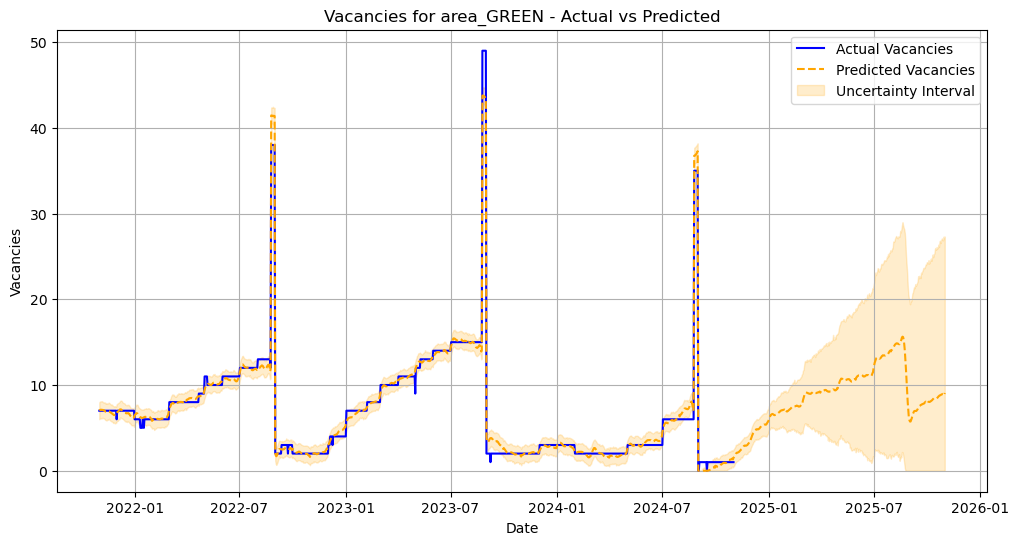

  0%|          | 0/2 [00:00<?, ?it/s]

20:07:10 - cmdstanpy - INFO - Chain [1] start processing
20:07:10 - cmdstanpy - INFO - Chain [1] done processing
20:07:10 - cmdstanpy - INFO - Chain [1] start processing
20:07:11 - cmdstanpy - INFO - Chain [1] done processing


   horizon        mse      rmse       mae     mdape     smape  coverage
0   9 days   0.846184  0.919882  0.710896  0.275978  0.254035       0.5
1  10 days   0.897902  0.947577  0.733136  0.301830  0.260533       0.5
2  11 days   0.932241  0.965526  0.753581  0.337643  0.265565       0.5
3  12 days   0.948639  0.973981  0.770515  0.348684  0.268991       0.5
4  13 days   0.953366  0.976404  0.783160  0.349923  0.271189       0.5
..     ...        ...       ...       ...       ...       ...       ...
77 86 days  36.516106  6.042856  5.678594  4.857105  1.474541       0.0
78 87 days  36.515153  6.042777  5.673936  4.857105  1.462522       0.0
79 88 days  36.666612  6.055296  5.684639  4.857105  1.451869       0.0
80 89 days  37.117401  6.092405  5.719459  4.857105  1.442472       0.0
81 90 days  37.565385  6.129061  5.759145  4.857105  1.434276       0.0

[82 rows x 7 columns]


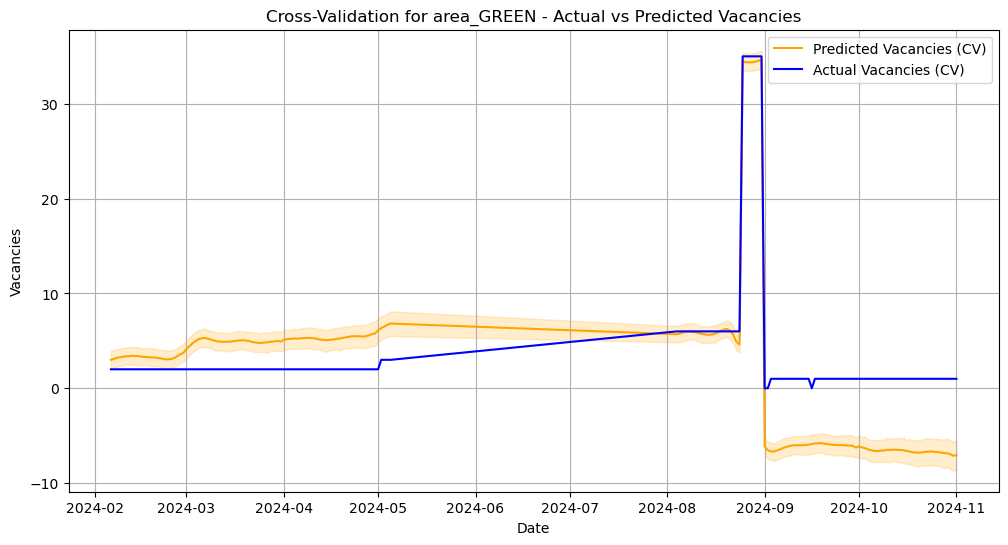

In [14]:
# Load your dataset for a single area
area = 'area_GREEN'  # Replace with your area column name
df_green = df[['ds', area]].rename(columns={area: 'y'})
df_green['end_of_month'] = df_green['ds'].dt.is_month_end.astype(int)
# Initialize Prophet model
model = Prophet(holidays=holidays, 
                yearly_seasonality=20,
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=15,
                seasonality_mode='additive')

# Add 'is_end_of_month' as a regressor
model.add_regressor('end_of_month')

# Fit the model
model.fit(df_green)

# Predict on future (1 year ahead)
future = model.make_future_dataframe(periods=365)

# Add the 'end_of_month' column to the future DataFrame
future['end_of_month'] = future['ds'].dt.is_month_end.astype(int)

forecast = model.predict(future)

# Clip the predicted values to ensure no negative values
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)

# Plot the forecast with actual values
plt.figure(figsize=(12, 6))
plt.plot(df_green['ds'], df_green['y'], label="Actual Vacancies", color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label="Predicted Vacancies", color='orange', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label="Uncertainty Interval")
plt.title(f"Vacancies for {area} - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.savefig('../plots/forecasted_gcb.png', dpi=300, bbox_inches='tight')
plt.show()

# Cross-validation:
# Set up cross-validation for Prophet
cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')

# Performance Metrics:
# Evaluate the performance of the model on the cross-validation results
metrics = performance_metrics(cv_results)
print(metrics)

# Plot Cross-Validation Results:
plt.figure(figsize=(12, 6))
plt.plot(cv_results['ds'], cv_results['yhat'], label="Predicted Vacancies (CV)", color='orange')
plt.plot(cv_results['ds'], cv_results['y'], label="Actual Vacancies (CV)", color='blue')
plt.fill_between(cv_results['ds'], cv_results['yhat_lower'], cv_results['yhat_upper'], color='orange', alpha=0.2)
plt.title(f"Cross-Validation for {area} - Actual vs Predicted Vacancies")
plt.xlabel("Date")
plt.ylabel("Vacancies")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Check the coefficients of the regressor
print(model.params['beta'])

[[ 3.74618e-02 -2.73767e-02  1.51939e-02  2.86584e-02 -2.10000e-02
  -1.41503e-03  1.10586e-02 -7.74110e-03 -1.83876e-03  1.45553e-02
  -4.60123e-03 -5.48040e-03  7.94743e-03 -4.78429e-03 -1.41044e-03
   6.98274e-03 -5.47487e-03 -5.40079e-03  6.86040e-03 -1.68625e-03
  -8.25863e-04  2.27921e-04 -9.81512e-05 -7.44532e-05  1.63965e-04
   2.30777e-04  6.71702e-01  6.82697e-01  6.93040e-01  7.03879e-01
   7.14247e-01  7.25235e-01  7.43162e-01  5.54793e-02 -7.15881e-03]]


In [12]:
forecast.to_csv('../data/predictions/forecast_green.csv', index = False)
df_green.to_csv('../data/predictions/df_green.csv', index = False)